In [18]:
import random
import csv
import matplotlib.pyplot as plt

In [19]:
def liters_to_gal(liters: float) -> float:
    return liters / 3.78541

In [20]:
# Define Constants
FILE_NAME = "data.csv"

# Time
FLIGHT_DAYS: int = 214
COLONY_DAYS: int = 3650

NUM_PEOPLE = 20

# ISS has 1920 liters of water for 7 people for 3 months
# https://ntrs.nasa.gov/api/citations/20180006341/downloads/20180006341.pdf
START_WATER = (7/3) * liters_to_gal(1920 * (NUM_PEOPLE / 7))

# https://www.nasa.gov/sites/default/files/atoms/files/mars_ice_drilling_assessment_v6_for_public_release.pdf
MAX_WATER_STORED = (NUM_PEOPLE) * liters_to_gal(1000 * 20)

END_OF_WATER_RATIONING = 60

MINING_FAIL_CHANCE = 0.05

MINING_SETUP_PERIOD = 60
DAYS_UNTIL_FARMING = 60
FARMING_WATER_USED = 140 / 7 # Soybeans require 140 gal per week

WATER_RATION_THRESHOLD = START_WATER * 2

RECYCLE_PERCENTAGE: float = 0.85

In [21]:
water_stored_list = []
water_used_list = []
water_lost_list = []
water_recycled_list = []
water_gained_list = []

# Water Extraction
total_water_gained: int = 0

# Simulation
current_water = 0

In [22]:
def get_recycle_percentage() -> float:
    """
    Recycling has a maximum of 85% efficiency, but some of the recycling machines may break, 
    decreasing efficiency (temporarily)
    """
    return (RECYCLE_PERCENTAGE + (random.random() * 0.1) - 0.05)


# Returns a random percentage up to 10% to indicate alteration
def get_water_deviation() -> float:
    #-5% to 5% deviation
    return random.random() * 0.2 - 0.1

    # Returns the water usage for an individual with the alterations accounted for


def get_individual_water_usage(base_water: float) -> float:
    return base_water * (1 + get_water_deviation())


def get_individual_space_water_usage() -> "tuple[float, float]":
    water_used = 0
    water_recycled = 0

    # ISS Astronauts use 3 gal per day
    water_used = 3
    water_used *= (1 + get_water_deviation())
    water_recycled = get_recycle_percentage() * water_used

    return (water_used, water_recycled)

In [16]:
def simulate() -> None:
    water_mined_per_day = int(
        input("What should be the maximum water mining capacity (in gallons)? "))

    global total_water_used
    global total_water_lost
    global total_water_recycled
    global total_water_gained
    global water_stored
    total_water_used = 0
    total_water_lost = 0
    total_water_recycled = 0
    total_water_gained = 0
    water_stored = 0

    global water_stored_list
    global water_used_list
    global water_lost_list
    global water_recycled_list
    global water_gained_list

    water_stored_list = []
    water_used_list = []
    water_lost_list = []
    water_recycled_list = []
    water_gained_list = []
    
    failed :bool = False

    # Open the CSV file in write mode and create a CSV writer
    with open(FILE_NAME, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer.writerow(["Day", "Water Stored", "Water Used Today", "Water Gained Today",
                        "Water Lost Today", "Water Recycled Today",
                        "Total Water Used", "Total Water Lost",
                        "Total Water Gained", "Total Water Recycled"])

        water_stored = START_WATER

        # During Flight
        for day in range(1, FLIGHT_DAYS + 1):
            if failed:
                water_stored_list.append(0)
                water_gained_list.append(0)
                water_recycled_list.append(0)
                water_used_list.append(0)
                water_lost_list.append(0)
                continue
            else:
                failed = water_stored <= 0
            water_used_today = 0
            water_lost_today = 0
            water_recycled_today = 0

            for x in range(NUM_PEOPLE):
                individual_water, individual_recycled = get_individual_space_water_usage()
                water_used_today += individual_water
                water_recycled_today += individual_recycled

            water_lost_today = water_used_today - water_recycled_today

            total_water_used += water_used_today
            total_water_lost += water_lost_today
            total_water_recycled += water_recycled_today

            water_stored -= water_lost_today
            water_stored = max(water_stored, 0)

            water_stored_list.append(water_stored)
            water_gained_list.append(0)
            water_recycled_list.append(water_recycled_today)
            water_used_list.append(water_used_today)
            water_lost_list.append(water_lost_today)

            # Save the data
            writer.writerow([day, water_stored, water_used_today, 0,
                            water_lost_today, water_recycled_today,
                            total_water_used, total_water_lost,
                            total_water_gained, total_water_recycled])

            # print(f"Day: {day} | Water Left: {water_stored} L | Water Used: {water_used_today} | ", end="")
            # print(f"Water Lost: {water_lost_today} L | Water Recycled: {water_recycled_today} | ", end="")
            # print(f"Total Water Used: {total_water_used} L | Total Water Lost: {total_water_lost} | ", end="")
            # print(f"Total Water Gained: {total_water_gained} L | Total Water Recycled: {total_water_recycled}")
        
        print("\nSpace water statistics: ")
        print(f"Water left in storage: {water_stored:.2f}")
        print(f"Total Water Used: {total_water_used:.2f} L | Total Water Lost: {total_water_lost:.2f}")
        print(f"Total Water Gained: {total_water_gained:.2f} L | Total Water Recycled: {total_water_recycled:.2f}")

        colonization_water_used = 0.0
        colonization_water_lost = 0.0
        colonization_water_gained = 0.0
        colonization_water_recycled = 0.0

        days_failing = 0
        fail_percent = 0
        mining_efficiency = 1

        # During Colonization
        for day in range(1, COLONY_DAYS + 1):
            if failed:
                water_stored_list.append(0)
                water_gained_list.append(0)
                water_recycled_list.append(0)
                water_used_list.append(0)
                water_lost_list.append(0)
                continue
            else:
                failed = water_stored <= 0
            water_used_today = 0
            water_lost_today = 0
            water_recycled_today = 0

            for x in range(NUM_PEOPLE):
                # Colonists split up water rations over a schedule 
                cycle = x + day
                if water_stored < WATER_RATION_THRESHOLD:
                    # 2.5 gal hygiene
                    # 1 gal drinking
                    individual_water = get_individual_water_usage(3.5)
                    if cycle % 3 == 0:
                        # shower (20 gal) (every 3 days)
                        individual_water += get_individual_water_usage(20)
                    if cycle % 4 == 0:
                        # Washing machine (15 gal) (every 4 days)
                        individual_water += get_individual_water_usage(15)
                    if cycle % 2 == 0:
                        # Dishwasher (5 gal) (every 2 days)
                        individual_water += get_individual_water_usage(5)
                elif water_stored < START_WATER:
                    # if there is nearly no water, cut water usage to only basic needs
                    individual_water = get_individual_water_usage(3.5)
                else:
                    # 5 gal dishwasher
                    # 20 gal shower
                    # space toilet = no water
                    # 2.5 gal hygiene
                    # 1 gal drinking
                    individual_water = get_individual_water_usage(5 + 20 + 2.5 + 1)
                    if cycle % 4 == 0:
                        # Washing machine (15 gal) (every 4 days)
                        individual_water += get_individual_water_usage(15)
                water_used_today += individual_water
                water_recycled_today += individual_water * get_recycle_percentage()

            if day > DAYS_UNTIL_FARMING:
                water_used_today += FARMING_WATER_USED

            water_lost_today = water_used_today - water_recycled_today

            # Mining productivity goes up 5% at a time for the first 30 days
            setup_factor = round(min(1, day / MINING_SETUP_PERIOD) * 20) / 20

            # 20% deviation in mining + setup factor
            water_mined_today = water_mined_per_day * (1 + random.random() * 0.4 - 0.2) * setup_factor * mining_efficiency

            # Mining efficiency will vary by up to +-5%
            mining_efficiency += (random.random() * 0.1 - 0.05)
            # Mining efficiency goes from 20 - 100%
            mining_efficiency = max(min(1, mining_efficiency), 0.2)

            # A machine can fail for up to 5 days
            if (random.random() < MINING_FAIL_CHANCE):
                days_failing = random.randint(1, 5)
                fail_percent = random.random()

            if (days_failing > 0):
                water_mined_today *= fail_percent
                days_failing -= 1

            water_gained_today = water_mined_today

            colonization_water_lost += water_lost_today
            colonization_water_used += water_used_today
            colonization_water_recycled += water_recycled_today
            colonization_water_gained += water_gained_today
            
            total_water_lost += water_lost_today
            total_water_used += water_used_today
            total_water_recycled += water_recycled_today
            total_water_gained += water_gained_today

            water_stored += water_gained_today - water_lost_today
            # Stop water stored from exceeding max
            water_stored = min(water_stored, MAX_WATER_STORED)
            water_stored = max(water_stored, 0)

            water_stored_list.append(water_stored)
            water_gained_list.append(water_gained_today)
            water_recycled_list.append(water_recycled_today)
            water_used_list.append(water_used_today)
            water_lost_list.append(water_lost_today)

            # Print daily statistics
            writer.writerow([day, water_stored, water_used_today, water_gained_today,
                            water_lost_today, water_recycled_today,
                            colonization_water_gained, colonization_water_lost,
                            colonization_water_gained, colonization_water_recycled])

        

        print("\nColonization water statistics: ")
        print(f"Water left in storage: {water_stored:.2f}")
        print(f"Colonization Water Used: {colonization_water_used:.2f} L | Colonization Water Lost: {colonization_water_lost:.2f}")
        print(f"Colonization Water Gained: {colonization_water_gained:.2f} L | Colonization Water Recycled: {colonization_water_recycled:.2f}")
        
        print("\nTotal statistics: ")
        print(f"Water left in storage: {water_stored:.2f}")
        print(f"Total Water Used: {total_water_used:.2f} L | Total Water Lost: {total_water_lost:.2f}")
        print(f"Total Water Gained: {total_water_gained:.2f} L | Total Water Recycled: {total_water_recycled:.2f}")
        
        print("\n\n")
        
        if failed:
            print("Colony ran out of water! Try again with a higher daily mining capacity.")
        else:
            print("Colony successful!")

In [28]:
def run():
    simulate()

    days_list = [day for day in range(1, FLIGHT_DAYS + COLONY_DAYS + 1)]

    fig, axs = plt.subplots(3)
    fig.set_size_inches(8, 6)
    fig.suptitle("Water Usage on Mars")
    fig.supxlabel("Days Since Mission Start")

    # for ax in axs:
    #     ax.xlabel("Days since mission launch")

    axs[0].plot(days_list, water_stored_list)
    axs[0].legend(["Water Stored"])
    axs[0].set(ylabel="Water (gal)")

    axs[1].scatter(days_list, water_used_list, c="red", s=0.5)
    axs[1].scatter(days_list, water_lost_list, c="orange", s=0.5)
    axs[1].scatter(days_list, water_recycled_list, c="green", s=0.5)
    axs[1].legend(["Water Used", "Water Lost", "Water Recycled"])
    axs[1].set(ylabel="Water (gal)")

    axs[2].scatter(days_list, water_gained_list, c="green", s=0.5)
    axs[2].legend(["Daily Water Mined"])
    axs[2].set(ylabel="Water (gal)")

    plt.show()

# Single-colony Water Simulation

Run the cell below using the Run button (or pressing Ctrl + Enter) to simulate a single colony.

What should be the maximum water mining capacity (in gallons)? 200

Space water statistics: 
Water left in storage: 1449.87
Total Water Used: 12830.52 L | Total Water Lost: 1931.53
Total Water Gained: 0.00 L | Total Water Recycled: 10898.99

Colonization water statistics: 
Water left in storage: 55883.03
Colonization Water Used: 2196920.74 L | Colonization Water Lost: 390712.51
Colonization Water Gained: 445145.67 L | Colonization Water Recycled: 1806208.23

Total statistics: 
Water left in storage: 55883.03
Total Water Used: 2209751.26 L | Total Water Lost: 392644.04
Total Water Gained: 445145.67 L | Total Water Recycled: 1817107.22


<IPython.core.display.Javascript object>


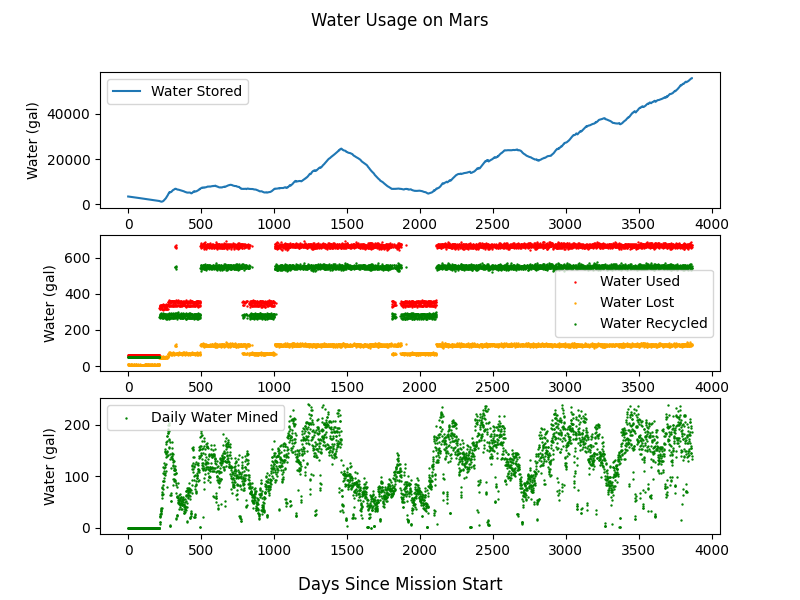

In [30]:
%matplotlib notebook

run()

Try this simulation for yourself! See the above cell for instructions.